# RNN_Eval.pynb

using PyTorch version  0.4.0

This is the notebook that will be for evaluation an already trained model. If torchtext is giving you issues, you can comment out the import torchtext, as long as you have the embedding matrix "index2word, word2index, embedding" the vocab class can work even without torchtext


In [98]:
import pickle
import random
import numpy as np
from re import split
import matplotlib.pyplot as plt

from carsonNLP.embedding import Vocabulary
from carsonNLP.string_token_functions import *

import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

print('you are using PyTorch version ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print('you have at least 1 GPU')
else:
    use_cuda = False
    print('no GPUs detected')

%load_ext autoreload
%autoreload 2
%matplotlib inline

you are using PyTorch version  0.4.0
no GPUs detected
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

Currently the data is stored in memory in dictionaries for the training validation and test set
where the key is the class and the value is a list of all the strings corresponding to that class

For the notebook that generates this dataset, see the data_preprocess folder and RS_to_data_dict.ipynb

emotrvaltest9.p
index of first validation sample -1100
index of first test sample -1000
addiction 71785
anxiety 81293
autism 28292
bipolar 61506
conversation 2118284
depression 179615
happy 50533
jokes 538659
schizophrenia 14137
selfharm 73660

Total = 3217764

In [ ]:
#f = open( "trvaltest/trvaltest_10cl_5-100words_v2.p", "rb")
f = open( "trvaltest/emotrvaltest6.p", "rb") # 
training_dict, validation_dict, test_dict, all_data, all_categories  \
= pickle.load(f, encoding="utf-8")
print(len(validation_dict['autism']))
print(validation_dict['happy'][4])

''' 
all_categories = ['addiction',
 'anxiety',
 'autism',
 'bipolar',
 'conversation',
 'depression',
 'happy',
 'jokes',
 'schizophrenia',
 'selfharm']
'''

all_categories = ['addiction',
 'anxiety',
 'autism',
 'bipolar',
 'conversation',
 'depression',
 'happy',
 'happy',
 'schizophrenia',
 'depression']
 


## index2word, word2index, embedding
Load the word embedding and the dictionaries for converting back and forth between the word as a string and it's index, the index2word has 4 more indices in it than the word2index because index2word has these extra tokens:

1. padding extra space, PAD, indexed at 0
2. start of sentence, SOS, indexed at 1
3. end of sentence, EOS, indexed at 2
4. unknown token, UNK, indexed at 3

To understand how the Vocabulary() class generates these embeddings and determine our vocabulary, see embedding.ipynb, to make a new set of index2word, word2index and embedding run this (requires torchtext):

`
glove = vocab.GloVe(name='6B', dim=100) # available in 100
print('Loaded {} words'.format(len(glove.itos)))
vocabClass = Vocabulary()
min_word_count = 5
path_to_folder_of_text = 'subreddit_posts'
index2word, word2index, embedding = vocabClass.makeEmbedding(min_word_count, glove, path_to_folder_of_text)
dicts_embed = (index2word, word2index, embedding)
pickle.dump(dicts_embed, open("embeddings/dicts_embed.p", "wb" ) )
`

In [87]:
index2word, word2index, embedding  = pickle.load( open( "embeddings/dicts_embed_min40_folder4.p", "rb" ) )
vocabClass = Vocabulary()
vocabClass.index2word = index2word
vocabClass.word2index = word2index

In [20]:
vocabClass.word2index["youre"]

9754

## Functions that support Training

Before we get started training lets go over some of the functions we will import to assist with the training process. If you look below at a few of the training / validation sentences you can see that in the raw data we have not yet made all the words lowercase and we have not added a space between the last word and the ending punctuation, ie 'Home?' should be 'home ?' so that 'home' and '?' are recognized as 2 separate tokens rather than the UNK token. 

In [30]:
n_categories = len(all_categories)
print('n_categories =', n_categories)
category = random.choice(all_categories)
print('example of category: ',category)
print(validation_dict[category][0])
print(all_categories)
vocabClass.word2index['thats']

n_categories = 10
example of category:  anxiety
so , it sounds like a good idea in theory , but i dont know if i will be able to stick to it . anyone else tried cutting back their screen time ? would be curious to know if it improved your life or if you have any advice for someone trying to cut back . thanks !
['addiction', 'anxiety', 'autism', 'bipolar', 'conversation', 'depression', 'happy', 'jokes', 'schizophrenia', 'selfharm']


19479

In [22]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        
        #self.fc1 = nn.Linear(hidden_size, hidden_size)
        
        self.fc1 = nn.Sequential(
                       nn.Linear(hidden_size*2, hidden_size),
                       #nn.BatchNorm1d(num_features=1), # NEW
                       nn.PReLU(),
                       nn.Linear(hidden_size, 1)
                    )

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)
        # print(' hidden.size(), encoder_outputs.size()', hidden.size(), encoder_outputs.size()) 
        # torch.Size([batch_size, hidden_size]) torch.Size([seq_len, batch_size, hidden_size])
        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, seq_len)) # B x S

        if use_cuda:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(seq_len):
                #attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))
                attn_energies[b, i] = self.score(hidden[b], encoder_outputs[i, b])

        attn_weights = F.softmax(attn_energies,dim=1).unsqueeze(1) # batch_size,1,seq_len
        
        return attn_weights 
    
    def score(self, hidden, encoder_output):
        #print(hidden.size(), encoder_output.size())
        #concat = torch.cat((hidden, encoder_output), 1)
        concat = torch.cat((hidden, encoder_output))
        energy = self.fc1(concat)
        return energy
        

In [88]:
class RNN(nn.Module):
    
    def __init__(self, hidden_size, embedding, output_size, num_layers = 3, bidirectional = False, 
                 train_embedding = True , dropout = 0.0):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(p=dropout) # p – probability of an element to be zeroed. Default: 0.5
        
        embedding = torch.from_numpy(embedding).float()
        
        if use_cuda:
            embedding.cuda()
        
        self.embedding = nn.Embedding(embedding.shape[0], embedding.shape[1])
        self.embedding.weight = nn.Parameter(embedding, requires_grad=train_embedding)
        self.gru = nn.GRU(embedding.shape[1], hidden_size, num_layers, 
                          bidirectional=bidirectional, dropout = dropout)
        
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1
        
        # make the initial hidden state learnable as well 
        hidden0 = torch.zeros(self.num_layers*num_directions, 1, self.hidden_size)
        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)
        
        self.num_cells = num_layers*num_directions
        
        self.fc_concat = nn.Sequential(
                             nn.Linear(hidden_size * 2, hidden_size),
                             nn.BatchNorm1d(num_features=self.hidden_size)
                             ) 
        
        self.fc1 = nn.Sequential(
                       nn.Linear(self.hidden_size,self.hidden_size),
                       nn.BatchNorm1d(num_features=self.hidden_size),
                       )
        
        self.out = nn.Linear(hidden_size,output_size)
        self.prelu = nn.PReLU()
        self.attn = Attn(hidden_size)

    def forward(self, input_seqs):
        
        batch_size = input_seqs.size(1)
        hidden = self.hidden0.repeat(1, batch_size, 1)
        self.embedded = self.embedding(input_seqs)
        encoder_outputs, last_seq_hidden = self.gru(self.embedded, hidden)
        last_hidden = last_seq_hidden[-1] 
        
        attn_weights = self.attn(last_hidden, encoder_outputs) #  batch_size,1,seq_len
        
        # output of GRU (seq_len, batch_size, hidden_size) -> (batch_size, seq_len, hidden_size)
        encoder_outputs_bsh = encoder_outputs.transpose(0, 1)
        
        # bmm does operation (b,1,s).bmm(b,s,h) = (b,1,h)
        context = torch.bmm(attn_weights,encoder_outputs_bsh) # should be  # B x S=1 x N
        
        # Attentional vector using the RNN hidden state and context vector concatenated together 
        context = context.squeeze(1)       # B x S=1 x H -> Batch Size x Hidden Size
        concat_input = torch.cat((last_hidden, context), 1) # both should be batch_size x hidden_size
        
        concat_output = F.tanh(self.fc_concat(concat_input)) # <hidden_size>

        fc1 = self.fc1(concat_output)

        output = self.out(self.dropout(fc1))
        #output = self.out(self.dropout(self.prelu(fc1)))
        
        return output, fc1 , attn_weights

## trained models

In [89]:
n_hidden = 256
num_layers = 3
bidirectional = False

rnn = RNN( n_hidden, embedding, n_categories, num_layers = num_layers, 
          bidirectional = bidirectional, dropout = 0.2)

criterion = nn.CrossEntropyLoss()

if use_cuda:
    rnn = rnn.cuda()

name = 'trvaltest_10cl_5-100w_embed_min40_v3_'+str(n_hidden)+'_'+str(num_layers)


In [90]:
def eval_validation(vocabClass):
    rnn.train(False)
    count = 0
    total_loss = 0
    total_correct = 0
    
    for category in validation_dict.keys():
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        if use_cuda:
            category_tensor = category_tensor.cuda()
        for line in validation_dict[category]:
            line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
            #print(line_tensor.size())
            if use_cuda:
                line_tensor = line_tensor.cuda()
            output, vector_rep, attn_wts = rnn(line_tensor)
            loss = criterion(output, category_tensor)
            total_loss += loss
            count += 1
            topv, topi = output.data.topk(1, 1, True)
            category_index = topi[0][0]
            if category == all_categories[category_index]:
                total_correct += 1
                
    avg_loss = float(total_loss)/count
    accuracy = float(total_correct)/count
    
    return avg_loss, accuracy

def predict_line(line, vocabClass, rnn):
        line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
        if use_cuda:
            line_tensor = line_tensor.cuda()
        rnn.train(False)
        output, rep, attn_wts = rnn(line_tensor)
        guess, guess_i = category_from_output(output)
        return guess, output, attn_wts

In [93]:
#name = 'trvaltest_10cl_5-100w_embed_min40_'+str(n_hidden)+'_'+str(num_layers)
#name = 'trvaltest_10cl_5-100w_embed_min40_v3_'+str(n_hidden)+'_'+str(num_layers)

rnn.load_state_dict(torch.load("modelstate/"+name+"_cpu.pth"))
avg_val_loss, val_accuracy = eval_validation(vocabClass)
print('avg_val_loss %.4f ,  val_accuracy %.4f' % (avg_val_loss, val_accuracy))

#save_model(rnn,name)
#name = 'tvt10_8cl_em0_'+str(n_hidden)+'_'+str(num_layers)

avg_val_loss 0.8419 ,  val_accuracy 0.8000


## Evaluation

/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


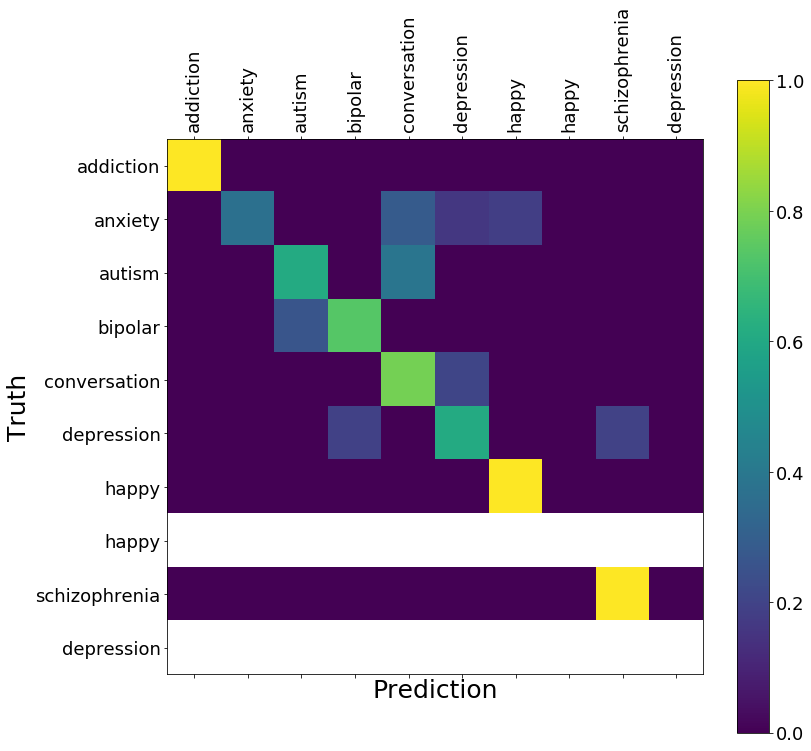

In [94]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

def random_training_pair(category_lines):                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
    if use_cuda:
        line_tensor = line_tensor.cuda()
        category_tensor = category_tensor.cuda()
    return category, line, category_tensor, line_tensor

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Just return an output given a line
def evaluate(line_tensor):
    rnn.train(False)
    output, rep, attn_wts = rnn(line_tensor)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair(test_dict)
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('Truth', fontsize=25)
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Confusion Matrix: actual language (rows) which language the network guesses (columns)

#fig.savefig("confusionMatrix.png")

In [95]:
def eval_dic(vocabClass, dic):
    
    group1 = ["selfharm","depression"]
    group2 = ["jokes","happy","conversation"]
    
    rnn.train(False)
    count = 0
    total_loss = 0
    total_correct = 0
    
    for category in dic.keys():
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        if use_cuda:
            category_tensor = category_tensor.cuda()
        for line in dic[category]:
            line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)

            if use_cuda:
                line_tensor = line_tensor.cuda()
            output, vector_rep, attn_wts = rnn(line_tensor)
            loss = criterion(output, category_tensor)
            total_loss += loss
            count += 1
            topv, topi = output.data.topk(1, 1, True)
            category_index = topi[0][0]
            if category == all_categories[category_index]:
                total_correct += 1
            elif category in group1 and all_categories[category_index] in group1:
                total_correct += 1
            elif category in group2 and all_categories[category_index] in group2:
                total_correct += 1
                
    avg_loss = float(total_loss)/count
    accuracy = float(total_correct)/count
    
    return avg_loss, accuracy



In [96]:
avg_loss, accuracy = eval_dic(vocabClass, validation_dict)
print('avg_val_loss %.4f ,  accuracy %.4f' % (avg_loss, accuracy)) 

avg_val_loss 0.8419 ,  accuracy 0.8031


In [97]:

string = " I havent been feeling optimistic now for awhile " 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

print(prediction)
print(output.cpu().detach().numpy())
print(attention_weights.cpu().detach().numpy())
print(vocabClass.normalize_string(string))


depression
[[  0.09525456   3.9678907   -5.45373      4.5288687   -1.0028174
    7.5918245    6.839463   -17.63648      0.5544319  -16.252825  ]]
[[[0.00522906 0.09384891 0.01608145 0.13845247 0.69376314 0.01241701
   0.00544407 0.02326413 0.01149972]]]
i havent been feeling optimistic now for awhile


In [99]:
bg_white_to_red_grad = plt.cm.get_cmap(name='Reds')

def turn_attn_weight_into_color(weight, tmp_cmap):
    color_indx = int(255 * weight)
    r, g, b, alpha = [int(255 * tmp_cmap(color_indx)[i]) for i in range(4)]
    return(r, g, b)

def get_word_with_rgb(word, r, g, b):
    esc = "\x1b["
    txt_style = "2;"  # Text style ("1" is bold, "2" is not bold)
    toggle_bg = "48;2;"  # Switch to toggle background color (38;2; is foreground color)
    r = str(r)  # Red
    g = str(g)  # Green
    b = str(b)  # Blue
    ansi_code = esc + txt_style + toggle_bg + r + ";" + g + ";" + b + "m"
    return("%s%s" % (ansi_code, word))

In [166]:
def predict_line(line, vocabClass, rnn):
        op_txt = ''
        my_cmap = plt.cm.get_cmap(name='Reds')
        tokens = split(' ', vocabClass.normalize_string(line))
        line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
        if use_cuda:
            line_tensor = line_tensor.cuda()
        output, rep, attn_wts = rnn(line_tensor)
        attn_weights = attn_wts.cpu().detach().numpy()[0][0][:-1]
        attn_weights = np.clip(attn_weights,0.0,2*np.mean(attn_weights))
        attn_weights /= np.sum(attn_weights)
        #print(attn_weights)
        guess, guess_i = category_from_output(output)
        for word_indx, word in enumerate(tokens):
            r, g, b = turn_attn_weight_into_color(attn_weights[word_indx], my_cmap)
            op_txt += get_word_with_rgb(word, r, g, b) + ' '
        # Note that we have to explicitly set the normal background to plain ol' white
        print('prediction: ', guess)
        print(op_txt + '\n')
        
        return guess, output, attn_wts


In [169]:
string = " I havent been feeling optimistic for awhile now" 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  depression
i havent been feeling optimistic for awhile now 



In [170]:
string = " I have been feeling more optimistic recently" 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  happy
i have been feeling more optimistic recently 



In [173]:
string = "the voices tell me to burn things" 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  schizophrenia
the voices tell me to burn things 



In [174]:
string = "did you hear Sandy broke up with Tim?" 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  conversation
did you hear sandy broke up with tim ? 



In [175]:
string = "My heart is beating so fast I feel like I will freese up tomorrow" 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  anxiety
my heart is beating so fast i feel like i will freese up tomorrow 

